In [1]:
import pandas as pd

from rdkit import Chem
from rdkit.Chem import AllChem
from tqdm import tqdm

from rdkit.DataStructs import TanimotoSimilarity


In [2]:
compounds = pd.read_csv('Information on compounds used in large electrophile library screening.csv')

In [3]:
compounds

,Compound,SMILES,Name
0,CL1,CC1=NC(=CS1)C=2C=CC=C(NC(=O)CCl)C2,"2-chloro-N-[3-(2-methyl-1,3-thiazol-4-yl)pheny..."
1,CL2,CN(C)C(=O)C=1C=CC(NC(=O)CCl)=CC1,"4-(2-chloroacetamido)-N,N-dimethylbenzamide"
2,CL3,CCC(NC(=O)CCl)C=1C=CC(Cl)=CC1,2-chloro-N-[1-(4-chlorophenyl)propyl]acetamide
3,CL4,CC=1C=C(Cl)C=CC1NC(=O)CCl,2-chloro-N-(4-chloro-2-methylphenyl)acetamide
4,CL5,ClCC(=O)NC1CCC2(CC1)OCCO2,"2-chloro-N-{1,4-dioxaspiro[4.5]decan-8-yl}acet..."
...,...,...,...
280,AC153,C=CC(=O)N1CCOC(CN2C=CN=N2)C1,"1-{2-[(1H-1,2,3-triazol-1-yl)methyl]morpholin-..."
281,AC154,CC=1C=NC(CCNC(=O)C=C)=CN1,N-[2-(5-methylpyrazin-2-yl)ethyl]prop-2-enamide
282,AC155,CC1=CSC(=N1)C2(CCOCC2)NC(=O)C=C,"N-[4-(4-methyl-1,3-thiazol-2-yl)oxan-4-yl]prop..."
283,AC156,CC1(C)CNC(=O)C1NC(=O)C=C,"N-(4,4-dimethyl-2-oxopyrrolidin-3-yl)prop-2-en..."


The first 128 molecules are with the Cl warhead

In [4]:
Cl_pattern = Chem.MolFromSmarts('C(=O)CCl')
def atom_remover(smiles,pattern=Cl_pattern):
    for smi in smiles:
        mol = Chem.MolFromSmiles(smi)
        match = mol.GetSubstructMatch(pattern)
        if not match:
            print('NOT REMOVING')
            yield Chem.Mol(mol)
        else:
            res = Chem.RWMol(mol)
            res.BeginBatchEdit()
            for aid in match:
                res.RemoveAtom(aid)
            res.CommitBatchEdit()
            Chem.SanitizeMol(res)
            res = Chem.Mol(res)
            yield res

In [5]:
cls_without_warhead = [x for x in atom_remover(compounds.iloc[:128]['SMILES'].values)]

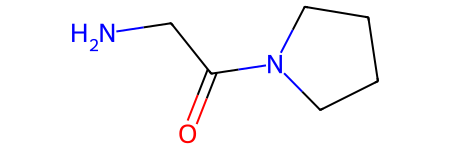

In [6]:
cls_without_warhead[127]

In [7]:
AC_pattern = Chem.MolFromSmarts('C(=O)C=C')
def atom_remover_al(smiles,pattern=AC_pattern):
    for smi in smiles:
        mol = Chem.MolFromSmiles(smi)
        match = mol.GetSubstructMatch(pattern)
        if not match:
            print('NOT REMOVING')
            yield Chem.Mol(mol)
        else:
            res = Chem.RWMol(mol)
            res.BeginBatchEdit()
            for aid in match:
                res.RemoveAtom(aid)
            res.CommitBatchEdit()
            Chem.SanitizeMol(res)
            res = Chem.Mol(res)
            yield res

In [8]:
al_without_warhead = [x for x in atom_remover_al(compounds.iloc[128:]['SMILES'].values)]

In [9]:
compounds['most_similar_ac_index'] = 0 
compounds['max_similarity_to_ac'] = 0.

In [10]:
for i,mol in tqdm(enumerate(cls_without_warhead)):
    morgan_fp = AllChem.GetMorganFingerprintAsBitVect(mol, 3)
    similarities = [TanimotoSimilarity(morgan_fp,AllChem.GetMorganFingerprintAsBitVect(x, 3)) for x in al_without_warhead]
    am = similarities.index(max(similarities))  # am stands for argmax, i.e. the index of the compound with highest similarity
    compounds['most_similar_ac_index'].iloc[i] = am + 128
    compounds['max_similarity_to_ac'].iloc[i] = max(similarities)

0it [00:00, ?it/s]/var/folders/xm/ht_73jb97b5gk0nqhsyggc640000gn/T/ipykernel_72162/1165151680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compounds['most_similar_ac_index'].iloc[i] = am + 128
/var/folders/xm/ht_73jb97b5gk0nqhsyggc640000gn/T/ipykernel_72162/1165151680.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compounds['max_similarity_to_ac'].iloc[i] = max(similarities)
128it [00:00, 152.68it/s]


In [12]:
compounds.sort_values('max_similarity_to_ac').tail(20)

,Compound,SMILES,Name,most_similar_ac_index,max_similarity_to_ac
110,CL111,Cl.ClCC(=O)N1CCN(CC=2C=CC=CC2)CC1,1-(4-benzylpiperazin-1-yl)-2-chloroethan-1-one...,224,0.360000
48,CL49,CC(NC(=O)CCl)C=1C=CC=C(Cl)C1,2-chloro-N-[1-(3-chlorophenyl)ethyl]acetamide,160,0.369565
22,CL23,ClCC(=O)NCC=1C=CC(Cl)=CC1,2-chloro-N-[(4-chlorophenyl)methyl]acetamide,229,0.370370
62,CL63,NC(=O)C1CCCN(C1)C(=O)CCl,1-(2-chloroacetyl)piperidine-3-carboxamide,210,0.375000
46,CL47,ClCC(=O)NC=1C=CC(=CC1)N2CCCC2=O,2-chloro-N-[4-(2-oxopyrrolidin-1-yl)phenyl]ace...,259,0.377358
25,CL26,ClCC(=O)NCCC=1C=CC=2OCCOC2C1,"2-chloro-N-[2-(2,3-dihydro-1,4-benzodioxin-6-y...",245,0.381818
78,CL79,FC=1C=CC=C(CNC(=O)CCl)C1,2-chloro-N-[(3-fluorophenyl)methyl]acetamide,229,0.413793
64,CL65,CNC(=O)CN1C=C(NC(=O)CCl)C=N1,2-chloro-N-{1-[(methylcarbamoyl)methyl]-1H-pyr...,233,0.428571
117,CL118,ClCC(=O)NCC=1C=CC(=NC1)N2CCOCC2,2-chloro-N-{[6-(morpholin-4-yl)pyridin-3-yl]me...,178,0.428571
122,CL123,FC=1C=C(NC(=O)CCl)C=CC1Cl,2-chloro-N-(4-chloro-3-fluorophenyl)acetamide,254,0.437500


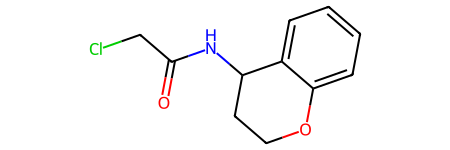

In [13]:
Chem.MolFromSmiles(compounds.iloc[58]['SMILES'])

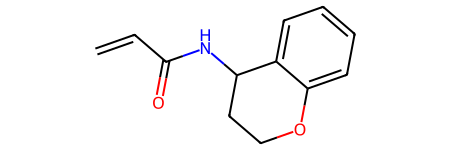

In [14]:
Chem.MolFromSmiles(compounds.iloc[271]['SMILES'])

In [15]:
similarity_above_04 = compounds.loc[compounds['max_similarity_to_ac'] >= 0.4]

In [16]:
similarity_above_04

,Compound,SMILES,Name,most_similar_ac_index,max_similarity_to_ac
4,CL5,ClCC(=O)NC1CCC2(CC1)OCCO2,"2-chloro-N-{1,4-dioxaspiro[4.5]decan-8-yl}acet...",164,1.000000
17,CL18,ClCC(=O)NCC1CCC1,2-chloro-N-(cyclobutylmethyl)acetamide,228,0.454545
58,CL59,ClCC(=O)NC1CCOC=2C=CC=CC12,"2-chloro-N-(3,4-dihydro-2H-1-benzopyran-4-yl)a...",271,1.000000
64,CL65,CNC(=O)CN1C=C(NC(=O)CCl)C=N1,2-chloro-N-{1-[(methylcarbamoyl)methyl]-1H-pyr...,233,0.428571
65,CL66,NS(=O)(=O)C=1C=CC(Cl)=C(NC(=O)CCl)C1,2-chloro-N-(2-chloro-5-sulfamoylphenyl)acetamide,150,0.525000
68,CL69,FC=1C=CC(NC(=O)CCl)=CC1F,"2-chloro-N-(3,4-difluorophenyl)acetamide",254,0.482759
74,CL75,ClCC(=O)NC=1C=CC=2OCOC2C1,"N-(2H-1,3-benzodioxol-5-yl)-2-chloroacetamide",193,0.452381
78,CL79,FC=1C=CC=C(CNC(=O)CCl)C1,2-chloro-N-[(3-fluorophenyl)methyl]acetamide,229,0.413793
81,CL82,ClCC(=O)NCC=1C=CC=2OCOC2C1,"N-[(2H-1,3-benzodioxol-5-yl)methyl]-2-chloroac...",193,1.000000
86,CL87,CC=1C=C(NC(=O)CCl)N(N1)C=2C=CC=CC2,2-chloro-N-(3-methyl-1-phenyl-1H-pyrazol-5-yl)...,130,0.450980


So, from this we could say that the compounds don't exaclty have common scaffold and pair relationship, but some of them do